In [2]:
import pandas as pd
import numpy as np

DATA_PATH = "/content/EEG.machinelearing_data_BRMH.csv.zip"

# Reads the first CSV inside the zip automatically
df = pd.read_csv(DATA_PATH, compression="zip")

display(df.head())
print("Shape:", df.shape)
print("\nDtypes count:\n", df.dtypes.value_counts())
print("\nMissing values (top 20):\n", df.isna().sum().sort_values(ascending=False).head(20))


,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


Shape: (945, 1149)

Dtypes count:
 float64    1144
object        4
int64         1
Name: count, dtype: int64

Missing values (top 20):
 Unnamed: 122            945
education                15
IQ                       13
COH.D.beta.j.Cz.s.O2      0
COH.D.beta.j.Cz.r.O1      0
COH.D.beta.j.Cz.q.T6      0
COH.D.beta.j.Cz.p.P4      0
COH.D.beta.j.Cz.o.Pz      0
COH.D.beta.j.Cz.n.P3      0
COH.D.beta.j.Cz.m.T5      0
COH.D.beta.j.Cz.l.T4      0
COH.D.beta.k.C4.l.T4      0
COH.D.beta.i.C3.s.O2      0
COH.D.beta.i.C3.r.O1      0
COH.D.beta.i.C3.q.T6      0
COH.D.beta.i.C3.p.P4      0
COH.D.beta.i.C3.o.Pz      0
COH.D.beta.i.C3.n.P3      0
COH.D.beta.i.C3.m.T5      0
COH.D.beta.j.Cz.k.C4      0
dtype: int64


In [3]:
# =========================
# CELL 1 — Minimal cleaning + target definition (3-class) + leakage control
# =========================
# Purpose:
#   1) Clean obvious non-informative columns (e.g., unnamed export columns, all-null columns).
#   2) Define a clinically interpretable 3-class target (DEP, HEALTHY, AUD) based on 'specific.disorder'.
#   3) Remove direct diagnostic columns from the feature space to prevent data leakage.
#   4) Prepare X (features) and y (labels) for baseline modeling.

import re

# -------------------------
# 1) Basic structural cleanup
# -------------------------
# Drop columns that are 100% missing (no information content).
all_null_cols = df.columns[df.isna().all()].tolist()

# Drop common spreadsheet export artifacts (e.g., "Unnamed: 0", "Unnamed: 122", etc.).
unnamed_cols = [c for c in df.columns if str(c).strip().lower().startswith("unnamed")]

cols_to_drop_initial = sorted(set(all_null_cols + unnamed_cols))
df_clean = df.drop(columns=cols_to_drop_initial, errors="ignore").copy()

print(f"Initial shape: {df.shape}")
print(f"Dropped all-null columns: {len(all_null_cols)}")
print(f"Dropped unnamed export columns: {len(unnamed_cols)}")
print(f"Clean shape: {df_clean.shape}")

# -------------------------
# 2) Target definition: 3 clinically interpretable classes
# -------------------------
# We use exact string matching to avoid ambiguous rule-based mapping.
# This aligns with a strong experimental assumption: classes come from the dataset's original labeling.
# NOTE: If the dataset uses slightly different strings, adjust the mapping below accordingly.

TARGET_COL = "y_3clases"

# Normalize for robust matching: lower-case + strip whitespace.
spec = df_clean["specific.disorder"].astype(str).str.strip().str.lower()

# Define allowed labels via a controlled mapping.
# Rationale:
#   - 'depressive disorder' vs 'healthy control' vs 'alcohol use disorder'
#   - Keeps task tractable and interpretable for a baseline.
label_map = {
    "depressive disorder": "DEP",
    "healthy control": "HEALTHY",
    "alcohol use disorder": "AUD",
}

df_clean[TARGET_COL] = spec.map(label_map)

# Filter to the 3 classes only (rows outside mapping become NaN).
df_3 = df_clean.dropna(subset=[TARGET_COL]).copy()

print("\nClass distribution (3-class subset):")
print(df_3[TARGET_COL].value_counts(dropna=False))

print(f"\n3-class dataset shape: {df_3.shape}")

# -------------------------
# 3) Leakage control: remove direct diagnostic columns from features
# -------------------------
# Direct diagnosis columns contain the answer (label) or near-proxies and will inflate metrics artificially.
# We remove them from X to ensure the model learns only from EEG-derived features + allowed covariates.

LEAKAGE_COLS = ["main.disorder", "specific.disorder", TARGET_COL]

# Some demographic columns (e.g., IQ, education) may be allowed, but be aware:
# they can introduce confounding/bias (not leakage, but a source of spurious correlations).
# For baseline viability, we keep them unless you decide to restrict to EEG-only later.

X = df_3.drop(columns=LEAKAGE_COLS, errors="ignore")
y = df_3[TARGET_COL].copy()

print("\nPrepared modeling matrices:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# -------------------------
# 4) Quick sanity checks (recommended before modeling)
# -------------------------
# Check for remaining object/categorical columns that will require encoding.
obj_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nObject/Categorical columns in X (require encoding):", len(obj_cols))
if len(obj_cols) > 0:
    print(obj_cols[:20])  # preview first 20

# Check missing values summary after filtering.
missing_top = X.isna().sum().sort_values(ascending=False).head(10)
print("\nTop missing-value columns in X:")
print(missing_top)

Initial shape: (945, 1149)
Dropped all-null columns: 1
Dropped unnamed export columns: 1
Clean shape: (945, 1148)

Class distribution (3-class subset):
y_3clases
DEP        199
HEALTHY     95
AUD         93
Name: count, dtype: int64

3-class dataset shape: (387, 1149)

Prepared modeling matrices:
X shape: (387, 1146)
y shape: (387,)

Object/Categorical columns in X (require encoding): 2
['sex', 'eeg.date']

Top missing-value columns in X:
education               6
IQ                      4
COH.D.beta.k.C4.m.T5    0
COH.D.beta.j.Cz.s.O2    0
COH.D.beta.j.Cz.r.O1    0
COH.D.beta.j.Cz.q.T6    0
COH.D.beta.j.Cz.p.P4    0
COH.D.beta.j.Cz.o.Pz    0
COH.D.beta.j.Cz.n.P3    0
COH.D.beta.j.Cz.m.T5    0
dtype: int64


In [4]:
# =========================
# CELL 2 — Baseline modeling (Dummy, Logistic Regression, Linear SVM) + CV diagnostics
# =========================
# Purpose:
#   1) Establish a "chance-level" baseline using DummyClassifier.
#   2) Establish a minimal acceptable supervised baseline with Logistic Regression (class_weight="balanced").
#   3) Add a strong high-dimensional baseline with Linear SVM (class_weight="balanced").
#   4) Use stratified cross-validation to obtain robust estimates (macro-F1 mean ± std).
#   5) Return training scores as a first-pass diagnostic of under/overfitting.
#
# Notes:
#   - We build full sklearn Pipelines to prevent data leakage:
#       preprocessing (impute/encode/scale) happens INSIDE each CV fold.
#   - Categorical features ('sex', 'eeg.date') are One-Hot Encoded.
#   - Numeric features are median-imputed and standardized.

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# -------------------------
# 1) Identify numeric vs categorical columns
# -------------------------
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.columns.difference(cat_cols).tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns count:", len(num_cols))

# -------------------------
# 2) Define preprocessing (inside CV folds)
# -------------------------
# Numeric pipeline:
#   - Median imputation is robust to outliers.
#   - Standardization is essential for linear models and SVM.
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline:
#   - Most-frequent imputation handles missing categories.
#   - OneHotEncoder converts categories into binary indicators.
#   - handle_unknown="ignore" prevents errors if a fold contains unseen categories.
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine numeric + categorical preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# -------------------------
# 3) Cross-validation configuration
# -------------------------
# StratifiedKFold preserves class proportions across folds.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We'll evaluate macro-F1, which is robust to class imbalance.
scoring = {"f1_macro": "f1_macro"}

# Helper: run CV and summarize results consistently
def eval_model(name: str, model_pipeline: Pipeline) -> dict:
    """
    Evaluate a model pipeline using stratified 5-fold CV.
    Returns mean and std for validation macro-F1, plus training macro-F1 diagnostics.
    """
    scores = cross_validate(
        model_pipeline,
        X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    out = {
        "model": name,
        "val_macro_f1_mean": float(np.mean(scores["test_f1_macro"])),
        "val_macro_f1_std": float(np.std(scores["test_f1_macro"])),
        "train_macro_f1_mean": float(np.mean(scores["train_f1_macro"])),
        "train_macro_f1_std": float(np.std(scores["train_f1_macro"])),
    }
    return out

results = []

# -------------------------
# 4) Baseline 0 — DummyClassifier (chance-level reference)
# -------------------------
# Strategy "most_frequent" is a conservative baseline: always predicts the majority class.
dummy = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_pipe = Pipeline(steps=[
    ("preprocess", preprocess),   # Keep preprocessing for consistency (safe; dummy ignores scale)
    ("clf", dummy)
])

results.append(eval_model("Dummy (most_frequent)", dummy_pipe))

# -------------------------
# 5) Baseline 1 — Logistic Regression (interpretable, standard baseline)
# -------------------------
# Multinomial logistic regression with balanced class weights.
# Solver choice:
#   - 'lbfgs' supports multinomial + is stable for many features.
logreg = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1
)

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", logreg)
])

results.append(eval_model("Logistic Regression (balanced)", logreg_pipe))

# -------------------------
# 6) Baseline 2 — Linear SVM (strong in high-dimensional settings)
# -------------------------
# LinearSVC is efficient for many features.
# Class weights help handle imbalance.
svm_linear = LinearSVC(
    class_weight="balanced",
    random_state=42
)

svm_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", svm_linear)
])

results.append(eval_model("Linear SVM (balanced)", svm_pipe))

# -------------------------
# 7) Display results table
# -------------------------
res_df = pd.DataFrame(results).sort_values(by="val_macro_f1_mean", ascending=False)

print("\n=== Baseline Results (5-fold Stratified CV) ===")
display(res_df)

# Interpretation tip (optional):
#   - If train_macro_f1_mean >> val_macro_f1_mean -> likely overfitting.
#   - If both are low -> likely underfitting or weak signal.

Categorical columns: ['sex', 'eeg.date']
Numeric columns count: 1144

=== Baseline Results (5-fold Stratified CV) ===


,model,val_macro_f1_mean,val_macro_f1_std,train_macro_f1_mean,train_macro_f1_std
1,Logistic Regression (balanced),0.607987,0.039384,1.000000,0.000000
2,Linear SVM (balanced),0.570273,0.052636,1.000000,0.000000
0,Dummy (most_frequent),0.226391,0.001420,0.226393,0.000352


Transformed X shape: (387, 1486)
Feature names count: 1486


,feature,f_score,p_value
1140,IQ,36.239301,3.827133e-15
1143,no.,34.946851,1.138668e-14
1142,education,17.354104,6.089645e-08
117,COH.A.delta.a.FP1.e.Fz,16.769819,1.041441e-07
288,COH.B.theta.a.FP1.e.Fz,15.738246,2.695724e-07
264,COH.A.delta.m.T5.n.P3,15.187860,4.486313e-07
435,COH.B.theta.m.T5.n.P3,14.502195,8.478108e-07
1141,age,13.639413,1.894156e-06
459,COH.C.alpha.a.FP1.e.Fz,11.600836,1.282806e-05
116,COH.A.delta.a.FP1.d.F3,11.224391,1.830107e-05


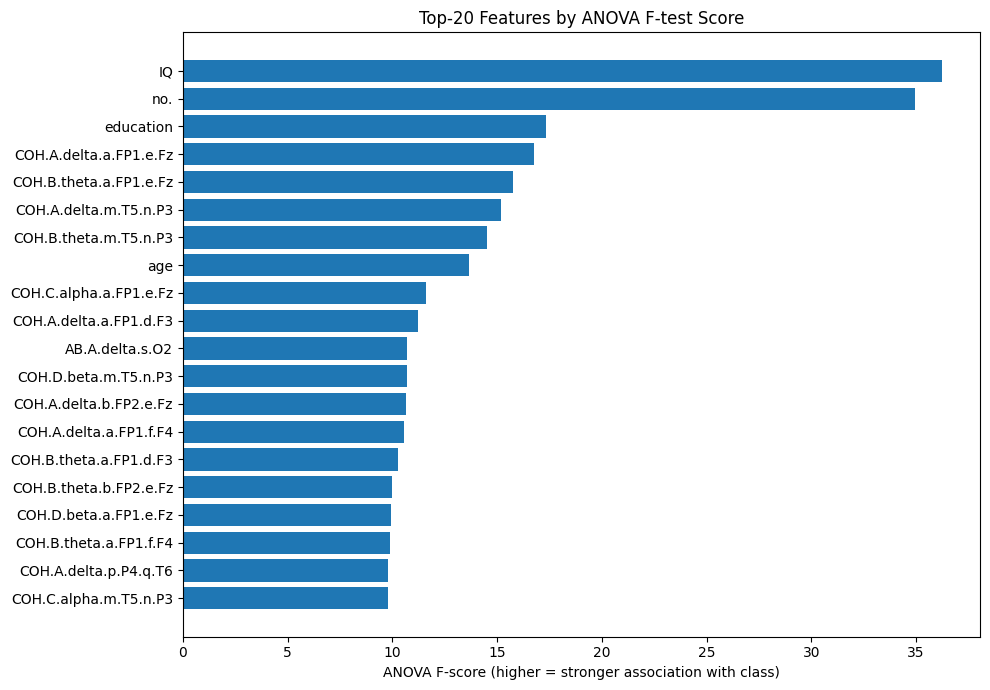


Family distribution within Top-50 features:
family
COH      38
Other     6
AB        6
Name: count, dtype: int64


In [5]:
# =========================
# CELL 3 — Feature relevance (ANOVA F-test) + visualization (Top-20 features)
# =========================
# Purpose:
#   1) Quantify feature relevance using a simple filter method: ANOVA F-test (SelectKBest).
#   2) Identify which individual variables are most associated with class separation.
#   3) Produce a Top-20 bar plot to satisfy the "feature importance" rubric requirement.
#
# Technical notes:
#   - ANOVA F-test is a univariate method: it evaluates each feature independently.
#   - We must apply the SAME preprocessing as in baseline modeling (imputation + encoding + scaling),
#     then compute ANOVA scores on the transformed feature matrix.
#   - IMPORTANT: For feature importance reporting, we fit on the full dataset ONLY for inspection.
#     Model performance must still rely on cross-validation (already done in Cell 2).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# -------------------------
# 1) Recreate preprocessing to obtain a numeric design matrix + feature names
# -------------------------
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.columns.difference(cat_cols).tolist()

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# Fit preprocessing on the full dataset to extract transformed matrix and feature names
X_trans = preprocess.fit_transform(X)

# Build feature names (numeric + one-hot expanded categorical)
num_feature_names = list(num_cols)

# One-hot feature names: sklearn provides get_feature_names_out in recent versions
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))

feature_names = num_feature_names + cat_feature_names

print("Transformed X shape:", X_trans.shape)
print("Feature names count:", len(feature_names))

# -------------------------
# 2) Compute ANOVA F-scores for all features
# -------------------------
# f_classif returns:
#   - F-statistic per feature
#   - p-values per feature
selector = SelectKBest(score_func=f_classif, k="all")
selector.fit(X_trans, y)

scores = selector.scores_
pvals = selector.pvalues_

# Defensive check: some features can be constant after preprocessing, producing NaNs.
scores = np.nan_to_num(scores, nan=0.0, posinf=0.0, neginf=0.0)
pvals = np.nan_to_num(pvals, nan=1.0, posinf=1.0, neginf=1.0)

anova_df = pd.DataFrame({
    "feature": feature_names,
    "f_score": scores,
    "p_value": pvals
}).sort_values("f_score", ascending=False)

display(anova_df.head(20))

# -------------------------
# 3) Visualize Top-20 features (bar plot)
# -------------------------
top_n = 20
top = anova_df.head(top_n).iloc[::-1]  # reverse for nicer horizontal plot

plt.figure(figsize=(10, 7))
plt.barh(top["feature"], top["f_score"])
plt.title(f"Top-{top_n} Features by ANOVA F-test Score")
plt.xlabel("ANOVA F-score (higher = stronger association with class)")
plt.tight_layout()
plt.show()

# -------------------------
# 4) Quick interpretability aid: how many top features are COH vs AB vs other?
# -------------------------
def family_tag(name: str) -> str:
    name_low = str(name).lower()
    if name_low.startswith("coh."):
        return "COH"
    if name_low.startswith("ab.") or name_low.startswith("ab_"):
        return "AB"
    return "Other"

anova_df["family"] = anova_df["feature"].apply(family_tag)

print("\nFamily distribution within Top-50 features:")
print(anova_df.head(50)["family"].value_counts())

In [6]:
# Add full KPI set: precision, recall, f1 (macro) + accuracy (reference)
scoring = {
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
    "accuracy": "accuracy"
}

In [7]:
out = {
    "model": name,
    "val_precision_macro_mean": float(np.mean(scores["test_precision_macro"])),
    "val_precision_macro_std": float(np.std(scores["test_precision_macro"])),
    "val_recall_macro_mean": float(np.mean(scores["test_recall_macro"])),
    "val_recall_macro_std": float(np.std(scores["test_recall_macro"])),
    "val_f1_macro_mean": float(np.mean(scores["test_f1_macro"])),
    "val_f1_macro_std": float(np.std(scores["test_f1_macro"])),
    "val_accuracy_mean": float(np.mean(scores["test_accuracy"])),
    "val_accuracy_std": float(np.std(scores["test_accuracy"])),

    "train_f1_macro_mean": float(np.mean(scores["train_f1_macro"])),
    "train_f1_macro_std": float(np.std(scores["train_f1_macro"])),
}

NameError: name 'name' is not defined

In [8]:
# =========================
# CELL 2 — Baseline modeling (Dummy, Logistic Regression, Linear SVM) + Full KPI set
# =========================
# Purpose:
#   1) Establish a "chance-level" reference using DummyClassifier.
#   2) Train simple supervised baselines (Logistic Regression, Linear SVM) suitable for high-dimensional tabular data.
#   3) Evaluate with Stratified 5-fold CV using a FULL KPI set requested by the advisor:
#        - Precision (macro)
#        - Recall (macro)
#        - F1 (macro)
#        - Accuracy (reference)
#   4) Return training scores (macro-F1) to diagnose potential overfitting under p >> n.
#
# Academic/technical notes:
#   - All preprocessing is performed INSIDE the sklearn Pipeline to avoid data leakage across CV folds.
#   - Numeric features: median imputation + standardization (required for LR/SVM stability).
#   - Categorical features: most-frequent imputation + one-hot encoding (handle unknown categories safely).
#   - Macro-averaging treats each class equally, which is appropriate under class imbalance.

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# -------------------------
# 1) Identify numeric vs categorical columns
# -------------------------
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.columns.difference(cat_cols).tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns count:", len(num_cols))

# -------------------------
# 2) Define preprocessing (executed within CV folds)
# -------------------------
# Numeric pipeline:
#   - Median imputation: robust to outliers and preserves sample size.
#   - StandardScaler: ensures comparable scales; critical for LR/SVM optimization.
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline:
#   - Most-frequent imputation: simple and stable for baseline models.
#   - OneHotEncoder: converts categories into a numeric design matrix.
#   - handle_unknown="ignore": prevents runtime errors when a fold contains unseen categories.
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# ColumnTransformer joins both branches into a single numeric matrix
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# -------------------------
# 3) Cross-validation configuration
# -------------------------
# Stratified folds preserve class proportions in each split.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# FULL KPI set requested:
# - Precision/Recall/F1 are macro-averaged (class-balanced view).
# - Accuracy is added only as a reference metric.
scoring = {
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
    "accuracy": "accuracy",
}

# Helper: consistent evaluation wrapper
def eval_model(name: str, model_pipeline: Pipeline) -> dict:
    """
    Evaluate a model pipeline via stratified 5-fold CV using multiple metrics.
    Returns validation mean/std for each KPI + training macro-F1 mean/std for overfitting diagnostics.
    """
    scores = cross_validate(
        model_pipeline,
        X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,   # gives train metrics for diagnosing overfitting
        n_jobs=-1
    )

    out = {
        "model": name,

        # Validation KPIs (macro-averaged where applicable)
        "val_precision_macro_mean": float(np.mean(scores["test_precision_macro"])),
        "val_precision_macro_std": float(np.std(scores["test_precision_macro"])),

        "val_recall_macro_mean": float(np.mean(scores["test_recall_macro"])),
        "val_recall_macro_std": float(np.std(scores["test_recall_macro"])),

        "val_f1_macro_mean": float(np.mean(scores["test_f1_macro"])),
        "val_f1_macro_std": float(np.std(scores["test_f1_macro"])),

        "val_accuracy_mean": float(np.mean(scores["test_accuracy"])),
        "val_accuracy_std": float(np.std(scores["test_accuracy"])),

        # Training macro-F1 (diagnostic only; do NOT claim generalization from this)
        "train_f1_macro_mean": float(np.mean(scores["train_f1_macro"])),
        "train_f1_macro_std": float(np.std(scores["train_f1_macro"])),
    }
    return out

results = []

# -------------------------
# 4) Baseline 0 — DummyClassifier (chance-level reference)
# -------------------------
# Strategy "most_frequent": predicts the majority class always (strong conservative baseline).
dummy = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", dummy)
])

results.append(eval_model("Dummy (most_frequent)", dummy_pipe))

# -------------------------
# 5) Baseline 1 — Logistic Regression (interpretable, standard baseline)
# -------------------------
# Multinomial LR is appropriate for multiclass.
# class_weight="balanced" mitigates class imbalance by reweighting the loss per class.
logreg = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1
)

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", logreg)
])

results.append(eval_model("Logistic Regression (balanced)", logreg_pipe))

# -------------------------
# 6) Baseline 2 — Linear SVM (strong in high-dimensional settings)
# -------------------------
# LinearSVC is efficient for many features; class_weight addresses imbalance.
svm_linear = LinearSVC(
    class_weight="balanced",
    random_state=42
)

svm_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", svm_linear)
])

results.append(eval_model("Linear SVM (balanced)", svm_pipe))

# -------------------------
# 7) Results table (sorted by validation macro-F1)
# -------------------------
res_df = pd.DataFrame(results).sort_values(by="val_f1_macro_mean", ascending=False)

print("\n=== Baseline Results (5-fold Stratified CV) — Full KPI Set ===")
display(res_df)

# -------------------------
# 8) Quick overfitting hint (textual)
# -------------------------
# If train_f1_macro_mean is near 1.0 while val_f1_macro_mean is much lower,
# this is consistent with overfitting under p >> n (many features, few samples).
best = res_df.iloc[0]
print(
    f"\nOverfitting diagnostic (best model): "
    f"train_macroF1={best['train_f1_macro_mean']:.3f} vs "
    f"val_macroF1={best['val_f1_macro_mean']:.3f}"
)

Categorical columns: ['sex', 'eeg.date']
Numeric columns count: 1144

=== Baseline Results (5-fold Stratified CV) — Full KPI Set ===


,model,val_precision_macro_mean,val_precision_macro_std,val_recall_macro_mean,val_recall_macro_std,val_f1_macro_mean,val_f1_macro_std,val_accuracy_mean,val_accuracy_std,train_f1_macro_mean,train_f1_macro_std
1,Logistic Regression (balanced),0.617840,0.048868,0.607171,0.038555,0.607987,0.039384,0.638095,0.028804,1.000000,0.000000
2,Linear SVM (balanced),0.581842,0.047335,0.569381,0.052982,0.570273,0.052636,0.602198,0.046857,1.000000,0.000000
0,Dummy (most_frequent),0.171406,0.001626,0.333333,0.000000,0.226391,0.001420,0.514219,0.004878,0.226393,0.000352



Overfitting diagnostic (best model): train_macroF1=1.000 vs val_macroF1=0.608


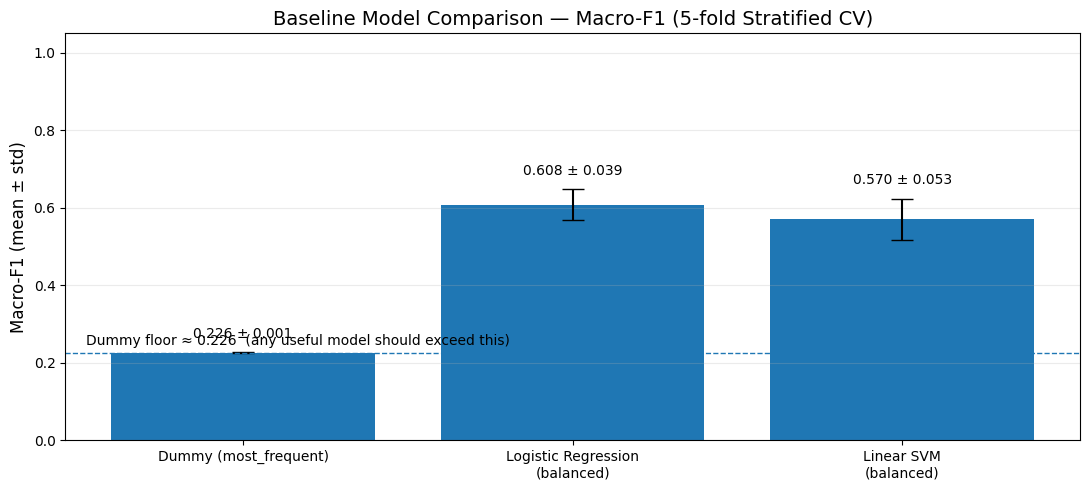

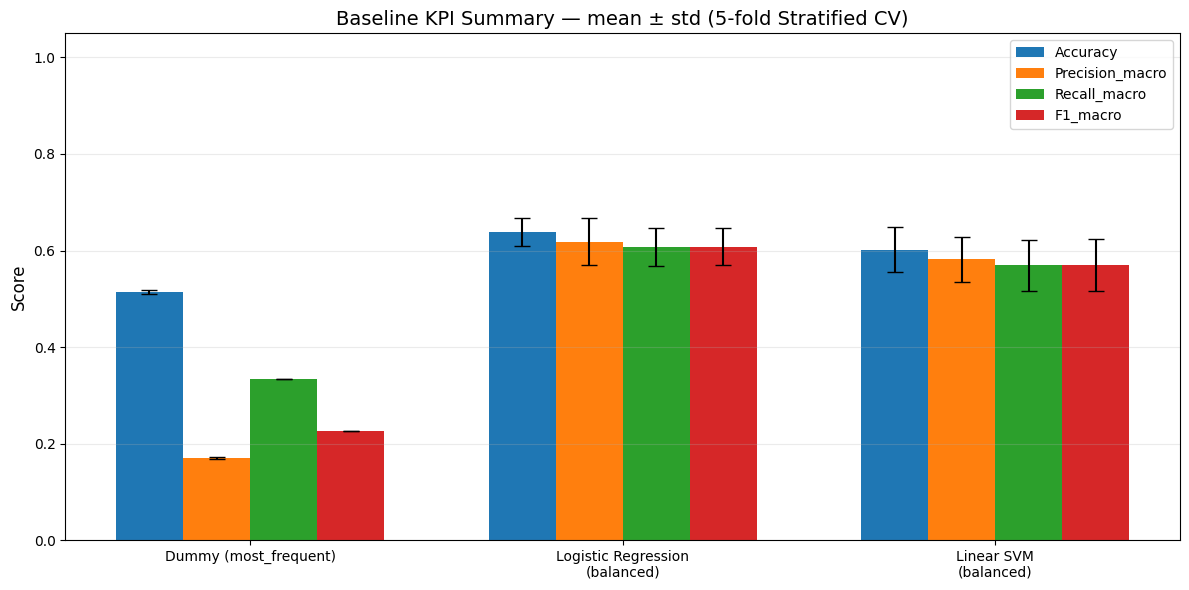

Δ Macro-F1 (LogReg vs Dummy) = 0.382  -> large improvement above chance baseline.


In [9]:
# ============================================================
# Cell X — Publication-style baseline comparison plots (Matplotlib)
# Purpose:
#   Produce clean, report-ready visualizations for:
#     1) Macro-F1 comparison (Dummy vs LR vs Linear SVM) with std error bars
#     2) (Optional) KPI panel: Accuracy, Precision_macro, Recall_macro, F1_macro
# Why:
#   These plots directly support the rubric: "Desempeño" + "Métrica"
#   and allow quick stakeholder interpretation of improvements vs chance baseline.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) INPUT METRICS (from your CV results)
# -----------------------------
# NOTE: Replace these numbers with your current run outputs if needed.
models = ["Dummy (most_frequent)", "Logistic Regression\n(balanced)", "Linear SVM\n(balanced)"]

# Macro-F1 (mean ± std)
f1_mean = np.array([0.226, 0.608, 0.570])
f1_std  = np.array([0.001, 0.039, 0.053])

# Accuracy (mean ± std) — optional
acc_mean = np.array([0.514, 0.638, 0.602])
acc_std  = np.array([0.005, 0.029, 0.047])

# Precision_macro (mean ± std) — optional
prec_mean = np.array([0.171, 0.618, 0.582])
prec_std  = np.array([0.002, 0.049, 0.047])

# Recall_macro (mean ± std) — optional
rec_mean = np.array([0.333, 0.607, 0.569])
rec_std  = np.array([0.000, 0.039, 0.053])

# -----------------------------
# 2) PLOT A: Macro-F1 comparison with error bars
# -----------------------------
x = np.arange(len(models))

fig = plt.figure(figsize=(11, 5))
ax = plt.gca()

bars = ax.bar(
    x, f1_mean,
    yerr=f1_std,
    capsize=8,
    linewidth=0
)

# Clean scientific styling (no custom colors required)
ax.set_title("Baseline Model Comparison — Macro-F1 (5-fold Stratified CV)", fontsize=14)
ax.set_ylabel("Macro-F1 (mean ± std)", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.set_ylim(0, 1.05)

# Annotate bar values (mean ± std)
for i, (m, s) in enumerate(zip(f1_mean, f1_std)):
    ax.text(i, m + s + 0.03, f"{m:.3f} ± {s:.3f}", ha="center", va="bottom", fontsize=10)

# Add a reference line for the "chance floor" (Dummy macro-F1)
dummy_floor = f1_mean[0]
ax.axhline(dummy_floor, linestyle="--", linewidth=1)
ax.text(
    0.02, dummy_floor + 0.02,
    f"Dummy floor ≈ {dummy_floor:.3f}  (any useful model should exceed this)",
    transform=ax.get_yaxis_transform(), fontsize=10
)

ax.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

# -----------------------------
# 3) PLOT B (Optional): KPI panel for each model
#    Accuracy + Precision_macro + Recall_macro + F1_macro with error bars
# -----------------------------
# This plot is useful if the doctor explicitly asks for "the 3 KPIs" + accuracy.
metrics = {
    "Accuracy": (acc_mean, acc_std),
    "Precision_macro": (prec_mean, prec_std),
    "Recall_macro": (rec_mean, rec_std),
    "F1_macro": (f1_mean, f1_std)
}

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()

# Bar group positions
k = len(metrics)
width = 0.18
offsets = (np.arange(k) - (k - 1) / 2) * width

for j, (metric_name, (mean_vals, std_vals)) in enumerate(metrics.items()):
    ax.bar(
        x + offsets[j], mean_vals,
        yerr=std_vals,
        width=width,
        capsize=6,
        label=metric_name,
        linewidth=0
    )

ax.set_title("Baseline KPI Summary — mean ± std (5-fold Stratified CV)", fontsize=14)
ax.set_ylabel("Score", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.set_ylim(0, 1.05)
ax.grid(axis="y", alpha=0.25)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# -----------------------------
# 4) Optional: Quick numeric interpretation printed for the report
# -----------------------------
delta_f1 = f1_mean[1] - f1_mean[0]
print(f"Δ Macro-F1 (LogReg vs Dummy) = {delta_f1:.3f}  -> large improvement above chance baseline.")

In [10]:
# ============================================================
# Cell — Learning Curves to diagnose overfitting (train vs CV)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# --- Assumption:
# X, y already prepared for the 3-class problem (DEP/AUD/HEALTHY)
# If you already have a full pipeline, replace `clf` with your pipeline.
clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    multi_class="multinomial",
    n_jobs=None
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=clf,
    X=X, y=y,
    cv=cv,
    scoring="f1_macro",
    train_sizes=np.linspace(0.2, 1.0, 6),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, marker="o", label="Train (macro-F1)")
plt.plot(train_sizes, val_mean, marker="o", label="Validation (macro-F1)")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.title("Learning Curves — Logistic Regression (balanced) | macro-F1")
plt.xlabel("Training set size")
plt.ylabel("macro-F1")
plt.ylim(0, 1.05)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1222, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'M'


Categorical columns: ['sex', 'eeg.date']
Numeric columns count: 1144


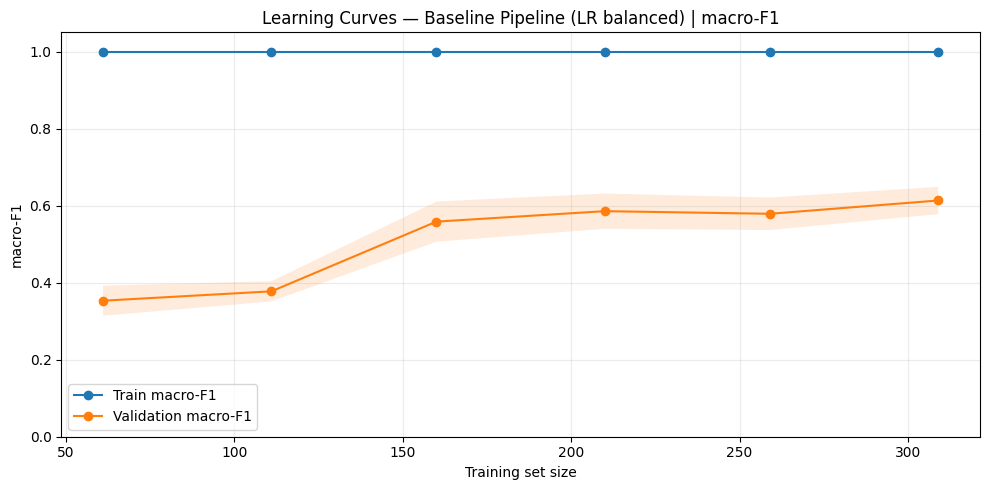

Interpretation guide:
- Persistent Train >> Validation gap = overfitting (common in p >> n).
- Low Train and low Validation = underfitting / weak signal.
- Converging curves at a decent value = good generalization.


In [11]:
# ============================================================
# Cell 7A (FIXED) — Learning Curves with proper preprocessing
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# ------------------------------------------------------------
# 1) Identify feature types (numeric vs categorical)
#    IMPORTANT: learning_curve will call .fit many times; therefore,
#    preprocessing MUST be inside a Pipeline to avoid data leakage.
# ------------------------------------------------------------
# X is expected to be a pandas DataFrame
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.columns.difference(categorical_cols).tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns count:", len(numeric_cols))

# ------------------------------------------------------------
# 2) Define preprocessing:
#    - Numeric: median imputation + standardization
#    - Categorical: most-frequent imputation + one-hot encoding
# ------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)

# ------------------------------------------------------------
# 3) Define the baseline model:
#    - Multinomial Logistic Regression
#    - class_weight="balanced" to reduce bias towards the majority class
# ------------------------------------------------------------
clf = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    multi_class="multinomial",
    solver="lbfgs"
)

# Full pipeline = preprocessing + model
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf)
])

# ------------------------------------------------------------
# 4) Compute learning curves under Stratified 5-fold CV
# ------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    cv=cv,
    scoring="f1_macro",
    train_sizes=np.linspace(0.2, 1.0, 6),
    n_jobs=-1,
)

# Aggregate mean/std across folds
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

# ------------------------------------------------------------
# 5) Plot
# ------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, marker="o", label="Train macro-F1")
plt.plot(train_sizes, val_mean, marker="o", label="Validation macro-F1")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15)

plt.title("Learning Curves — Baseline Pipeline (LR balanced) | macro-F1")
plt.xlabel("Training set size")
plt.ylabel("macro-F1")
plt.ylim(0, 1.05)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretation guide:")
print("- Persistent Train >> Validation gap = overfitting (common in p >> n).")
print("- Low Train and low Validation = underfitting / weak signal.")
print("- Converging curves at a decent value = good generalization.")

,fold,train_f1_macro,val_f1_macro,train_precision_macro,val_precision_macro,train_recall_macro,val_recall_macro,train_accuracy,val_accuracy
0,1,1.0,0.614874,1.0,0.623669,1.0,0.610088,1.0,0.641026
1,2,1.0,0.681300,1.0,0.709402,1.0,0.680263,1.0,0.692308
2,3,1.0,0.592444,1.0,0.600000,1.0,0.590193,1.0,0.623377
3,4,1.0,0.576485,1.0,0.573572,1.0,0.582700,1.0,0.610390
4,5,1.0,0.574831,1.0,0.582558,1.0,0.572612,1.0,0.623377


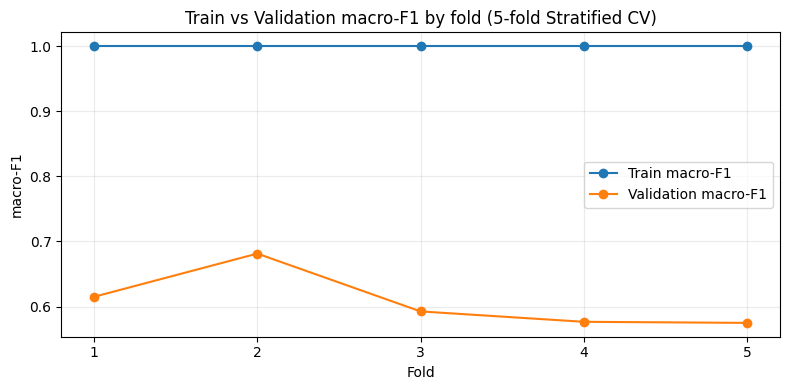

Mean gap (train - val) macro-F1: 0.39201329296129833


In [12]:
# ============================================================
# Cell 7B — Train vs Validation metrics by fold (generalization gap)
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

cv_out = cross_validate(
    estimator=model,      # IMPORTANT: the full pipeline (preprocess + LR)
    X=X, y=y,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

fold_df = pd.DataFrame({
    "fold": range(1, 6),
    "train_f1_macro": cv_out["train_f1_macro"],
    "val_f1_macro": cv_out["test_f1_macro"],
    "train_precision_macro": cv_out["train_precision_macro"],
    "val_precision_macro": cv_out["test_precision_macro"],
    "train_recall_macro": cv_out["train_recall_macro"],
    "val_recall_macro": cv_out["test_recall_macro"],
    "train_accuracy": cv_out["train_accuracy"],
    "val_accuracy": cv_out["test_accuracy"],
})

display(fold_df)

# Simple visualization: macro-F1 gap by fold
plt.figure(figsize=(8, 4))
plt.plot(fold_df["fold"], fold_df["train_f1_macro"], marker="o", label="Train macro-F1")
plt.plot(fold_df["fold"], fold_df["val_f1_macro"], marker="o", label="Validation macro-F1")
plt.xticks(fold_df["fold"])
plt.xlabel("Fold")
plt.ylabel("macro-F1")
plt.title("Train vs Validation macro-F1 by fold (5-fold Stratified CV)")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

print("Mean gap (train - val) macro-F1:",
      (fold_df["train_f1_macro"] - fold_df["val_f1_macro"]).mean())

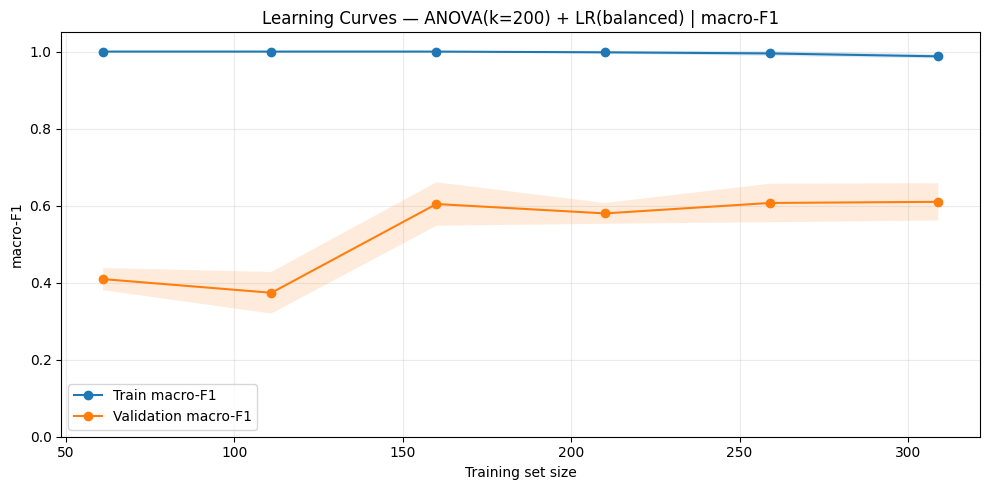

In [13]:
# ============================================================
# Cell 7C — Mitigation attempt: ANOVA SelectKBest + LR (balanced)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, learning_curve

k = 200  # try 100/200/300 and report sensitivity

model_anova = Pipeline(steps=[
    ("preprocess", preprocess),                 # same preprocessing
    ("selectk", SelectKBest(f_classif, k=k)),   # supervised feature filtering
    ("clf", clf)                                # same LR baseline
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=model_anova,
    X=X, y=y,
    cv=cv,
    scoring="f1_macro",
    train_sizes=np.linspace(0.2, 1.0, 6),
    n_jobs=-1,
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, marker="o", label="Train macro-F1")
plt.plot(train_sizes, val_mean, marker="o", label="Validation macro-F1")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.title(f"Learning Curves — ANOVA(k={k}) + LR(balanced) | macro-F1")
plt.xlabel("Training set size")
plt.ylabel("macro-F1")
plt.ylim(0, 1.05)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Gap table (train - val) for macro-F1 per fold
fold_df["gap_f1_macro"] = fold_df["train_f1_macro"] - fold_df["val_f1_macro"]
display(fold_df[["fold", "train_f1_macro", "val_f1_macro", "gap_f1_macro"]])

print("Mean gap:", fold_df["gap_f1_macro"].mean())
print("Std  gap:", fold_df["gap_f1_macro"].std())

,fold,train_f1_macro,val_f1_macro,gap_f1_macro
0,1,1.0,0.614874,0.385126
1,2,1.0,0.681300,0.318700
2,3,1.0,0.592444,0.407556
3,4,1.0,0.576485,0.423515
4,5,1.0,0.574831,0.425169


Mean gap: 0.39201329296129833
Std  gap: 0.044032528504236085
